# PML Debug & Tuning — Outer-collar baseline

Goal: lock a trustworthy PDE baseline (stencil + PML collar) **before** dataset generation.

## What “good” looks like
- Re(u), Im(u) on the physical domain show clean outgoing waves with minimal boundary artifacts.
- PML collar absorbs: mean |u|² decays strongly into the collar (log scale).
- Metrics are small:
  - M2_outer_ring (energy near outer boundary / interior energy) ↓
  - M3_decay_ratio (outer boundary / interface energy) ↓
- PPW constraint satisfied at highest ω.

## Convention
- Physical domain has fixed location (do **not** shift it).
- PML is an **outer collar** outside the physical domain.
- For lineouts we shift x so that **core starts at x=0** (PML on x<0).


In [1]:
import importlib
import core.resolution as cres
import operators.solve as opsolve
importlib.reload(cres)
importlib.reload(opsolve)
print("resolution.py:", cres.__file__)
print("solve.py:", opsolve.__file__)


resolution.py: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\core\resolution.py
solve.py: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\operators\solve.py


In [2]:
from __future__ import annotations

import sys
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, Any

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 120

# --- locate project root / src ---
PROJECT_ROOT = Path.cwd()
SRC_ROOT = PROJECT_ROOT / "src"
if not SRC_ROOT.exists():
    maybe = PROJECT_ROOT.parent / "src"
    if maybe.exists():
        SRC_ROOT = maybe

if SRC_ROOT.exists() and str(SRC_ROOT) not in sys.path:
    sys.path.insert(0, str(SRC_ROOT))

print("CWD:", PROJECT_ROOT)
print("SRC_ROOT:", SRC_ROOT, "exists:", SRC_ROOT.exists())

# --- project imports ---
from core.config import Grid2D, HelmholtzConfig, PMLConfig
from core.cases import make_default_cases
from core.medium import build_medium
from core.rhs import assemble_rhs

from operators.pml import build_pml_profiles
from operators.solve import solve_on_extended_domain

print("Imports OK ✅")


CWD: c:\Users\31624\Documents\MIT\Programming\Freq2Transfer\experiments
SRC_ROOT: c:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src exists: True
Imports OK ✅


## Physical grid + PPW check

We enforce PPW ≥ 10 at the highest ω.
For constant c=1:

- wavelength λ = 2π/ω
- ppw = λ / h


In [4]:
# Physical domain size
Lx = Ly = 1.0

# Physical grid size
n_phys = 257
grid_phys = Grid2D(nx=n_phys, ny=n_phys, lx=Lx, ly=Ly, x_min=0.0, y_min=0.0)

# Powers-of-two ω
OMEGAS = [32.0, 64.0, 128.0]

# Constant wave speed
c_min = 1.0

h = float(grid_phys.hx)

def ppw(omega: float) -> float:
    # λ = 2π c / ω, ppw = λ / h
    return float(2*np.pi*c_min/(omega*h))

print("grid_phys:", grid_phys)
print("h =", h)
for w in OMEGAS:
    print(f"omega={w:>6.1f} -> ppw={ppw(w):.2f}")

assert ppw(max(OMEGAS)) >= 10.0 - 1e-12, "PPW < 10 at highest ω; increase n_phys"
print("PPW constraint satisfied ✅")


grid_phys: Grid2D(nx=257, ny=257, lx=1.0, ly=1.0, x_min=0.0, y_min=0.0)
h = 0.00390625
omega=  32.0 -> ppw=50.27
omega=  64.0 -> ppw=25.13
omega= 128.0 -> ppw=12.57
PPW constraint satisfied ✅


## Case selection

Pick the simplest case first (constant medium + simple RHS).


In [5]:
cases = make_default_cases()
print("Available cases:", list(cases.keys()))

CASE_NAME = "const"
assert CASE_NAME in cases, f"Case '{CASE_NAME}' not found. Available: {list(cases.keys())}"
case = cases[CASE_NAME]
print("Using case:", CASE_NAME, case)

# Precompute mesh once (physical grid is fixed)
X_phys, Y_phys = grid_phys.mesh()


Available cases: ['const']
Using case: const CaseConfig(name='const', c0=1.0, c_func=None, rhs_func=None)


## RHS shape guard

`solve_on_extended_domain` expects a 2D RHS with shape (nx, ny).  
Some RHS builders return a flattened vector; we reshape it safely.


In [6]:
def as_phys_2d(arr: np.ndarray, grid: Grid2D, name: str = "array") -> np.ndarray:
    nx, ny = int(grid.nx), int(grid.ny)

    if arr.ndim == 2:
        if arr.shape == (nx, ny):
            return arr
        if arr.shape == (ny, nx):
            return arr.T
        raise ValueError(f"{name} must be shape {(nx, ny)} (or {(ny, nx)}); got {arr.shape}")

    if arr.ndim == 1:
        if arr.size != nx * ny:
            raise ValueError(f"{name} must have size {nx*ny} for flatten->2D; got {arr.size}")
        return arr.reshape((nx, ny))

    raise ValueError(f"{name} must be 1D or 2D; got ndim={arr.ndim}")


## Plot helpers

- 2D Re/Im uses physical coordinate extents of the corresponding grid.
- Lineouts are plotted with **core starting at x=0**, so PML collar appears on x<0.


In [7]:
def plot_re_im_with_extent(U: np.ndarray, grid: Grid2D, main_title: str, subtitle: str):
    extent = [grid.x_min, grid.x_max, grid.y_min, grid.y_max]

    fig, ax = plt.subplots(1, 2, figsize=(11, 4))
    im0 = ax[0].imshow(U.real, origin="lower", extent=extent)
    ax[0].set_title("Re(u)")
    ax[0].set_xlabel("x"); ax[0].set_ylabel("y")
    plt.colorbar(im0, ax=ax[0], fraction=0.046, pad=0.04)

    im1 = ax[1].imshow(U.imag, origin="lower", extent=extent)
    ax[1].set_title("Im(u)")
    ax[1].set_xlabel("x"); ax[1].set_ylabel("y")
    plt.colorbar(im1, ax=ax[1], fraction=0.046, pad=0.04)

    fig.suptitle(main_title, fontsize=14, y=1.05)
    fig.text(0.5, 0.98, subtitle, ha="center", fontsize=10)
    plt.tight_layout()
    plt.show()


def plot_lineouts_core_origin(U_ext: np.ndarray, grid_ext: Grid2D, *, npml: int, title: str):
    """
    Lineouts where:
      x=0 is the LEFT PML–core interface
      x<0 is left PML collar
      x in [0, L_core] is the physical core
      x>L_core is right collar
    """
    n = U_ext.shape[0]
    mid = n // 2

    hx = float(grid_ext.hx)
    hy = float(grid_ext.hy)

    # shift so interface index npml becomes coordinate 0
    x = (np.arange(n) - npml) * hx
    y = (np.arange(n) - npml) * hy

    n_core = n - 2*npml
    L_core_x = (n_core - 1) * hx
    L_core_y = (n_core - 1) * hy

    # Horizontal lineout
    plt.figure(figsize=(10, 3.5))
    plt.plot(x, U_ext.real[mid, :], label="Re(u) along y=mid")
    plt.plot(x, U_ext.imag[mid, :], label="Im(u) along y=mid")
    plt.axvline(0.0, linestyle="--", linewidth=1)
    plt.axvline(L_core_x, linestyle="--", linewidth=1)
    plt.title(title + " — horizontal lineout (core starts at x=0)")
    plt.xlabel("x (PML at x<0)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Vertical lineout
    plt.figure(figsize=(10, 3.5))
    plt.plot(y, U_ext.real[:, mid], label="Re(u) along x=mid")
    plt.plot(y, U_ext.imag[:, mid], label="Im(u) along x=mid")
    plt.axvline(0.0, linestyle="--", linewidth=1)
    plt.axvline(L_core_y, linestyle="--", linewidth=1)
    plt.title(title + " — vertical lineout (core starts at y=0)")
    plt.xlabel("y (PML at y<0)")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Reflection metrics + PML decay

- **M2_outer_ring**: energy in an outer ring / interior energy (lower is better).
- **M3_decay_ratio**: outer boundary mean |u|² / interface mean |u|² (lower is better).
- Decay profile: mean |u|² vs depth into PML on each side (log scale).


In [8]:
def core_slices(npml: int, n: int):
    if 2*npml >= n:
        raise ValueError(f"npml={npml} too large for n={n}")
    return (slice(npml, n-npml), slice(npml, n-npml))

def ring_mask(shape, ring: int):
    ny, nx = shape
    m = np.zeros((ny, nx), dtype=bool)
    m[:ring, :] = True
    m[-ring:, :] = True
    m[:, :ring] = True
    m[:, -ring:] = True
    return m

def energy(z):
    return float(np.sum(np.abs(z)**2))

def reflection_metrics(U: np.ndarray, npml: int, *, ring: int = 8, outer_ring: int = 8):
    n = U.shape[0]
    cs = core_slices(npml, n)
    core = U[cs[0], cs[1]]

    m1 = ring_mask(core.shape, ring=ring)
    Ein = energy(core[~m1]) + 1e-30

    M1 = energy(core[m1]) / Ein
    m2 = ring_mask(U.shape, ring=outer_ring)
    M2 = energy(U[m2]) / Ein

    left_int  = npml
    right_int = n - npml - 1
    bot_int   = npml
    top_int   = n - npml - 1

    E_int = (
        float(np.mean(np.abs(U[cs[0], left_int]) ** 2)) +
        float(np.mean(np.abs(U[cs[0], right_int]) ** 2)) +
        float(np.mean(np.abs(U[bot_int, cs[1]]) ** 2)) +
        float(np.mean(np.abs(U[top_int, cs[1]]) ** 2))
    ) / 4.0

    E_out = (
        float(np.mean(np.abs(U[cs[0], 0]) ** 2)) +
        float(np.mean(np.abs(U[cs[0], n-1]) ** 2)) +
        float(np.mean(np.abs(U[0, cs[1]]) ** 2)) +
        float(np.mean(np.abs(U[n-1, cs[1]]) ** 2))
    ) / 4.0

    M3 = E_out / (E_int + 1e-30)

    return {"M1_core_ring": float(M1), "M2_outer_ring": float(M2), "M3_decay_ratio": float(M3)}

def pml_decay_profile(U: np.ndarray, npml: int):
    n = U.shape[0]
    cs = core_slices(npml, n)
    prof = {k: np.zeros(npml, dtype=float) for k in ["left", "right", "bottom", "top"]}

    for d in range(npml):
        xL = npml - 1 - d
        xR = (n - npml) + d
        yB = npml - 1 - d
        yT = (n - npml) + d

        prof["left"][d]   = float(np.mean(np.abs(U[cs[0], xL])**2))
        prof["right"][d]  = float(np.mean(np.abs(U[cs[0], xR])**2))
        prof["bottom"][d] = float(np.mean(np.abs(U[yB, cs[1]])**2))
        prof["top"][d]    = float(np.mean(np.abs(U[yT, cs[1]])**2))

    return prof

def plot_pml_decay(prof, *, title: str):
    d = np.arange(len(next(iter(prof.values()))))
    plt.figure(figsize=(8, 4))
    for k, v in prof.items():
        plt.semilogy(d, v + 1e-30, label=k)
    plt.title(title + " — mean |u|^2 vs depth into PML (log scale)")
    plt.xlabel("depth into PML (0=interface → outward)")
    plt.ylabel("mean |u|^2")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Single baseline run (outer collar)

This is the “does everything work, and does it look right?” run.


In [9]:
import operators.solve as opsolve
print("solve.py path:", opsolve.__file__)

import inspect
src = inspect.getsource(opsolve.solve_on_extended_domain)
print("x_min_phys used?", "x_min_phys=float(x_min_phys)" in src)
print("hard-coded 0.0?", "x_min_phys=0.0" in src)


solve.py path: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\operators\solve.py
x_min_phys used? True
hard-coded 0.0? False


Using solve_on_extended_domain from: C:\Users\31624\Documents\MIT\Programming\Freq2Transfer\src\operators\solve.py
Signature: (*, omega: 'float', ppw: 'float', lx: 'float', ly: 'float', npml: 'int', m: 'int', eta: 'float', c_phys: 'np.ndarray', f_phys_2d: 'np.ndarray', c_min_for_grid: 'float' = 1.0, n_min_phys: 'int' = 501, make_odd_phys: 'bool' = True, x_min_phys: 'float' = 0.0, y_min_phys: 'float' = 0.0, c_ref: 'Optional[float]' = None, rhs_fill_value: 'float' = 0.0, debug: 'bool' = False) -> 'Dict[str, Any]'


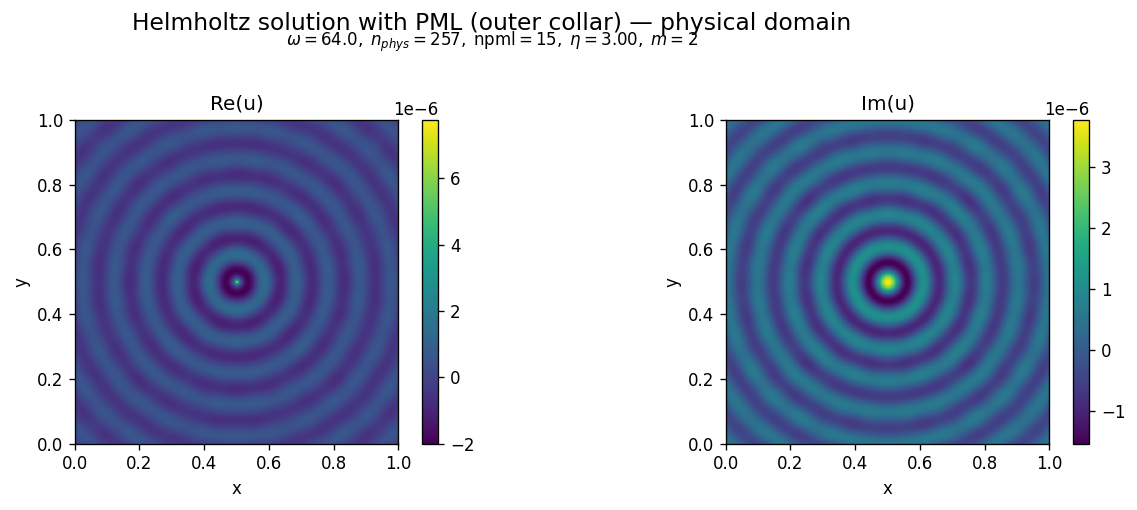

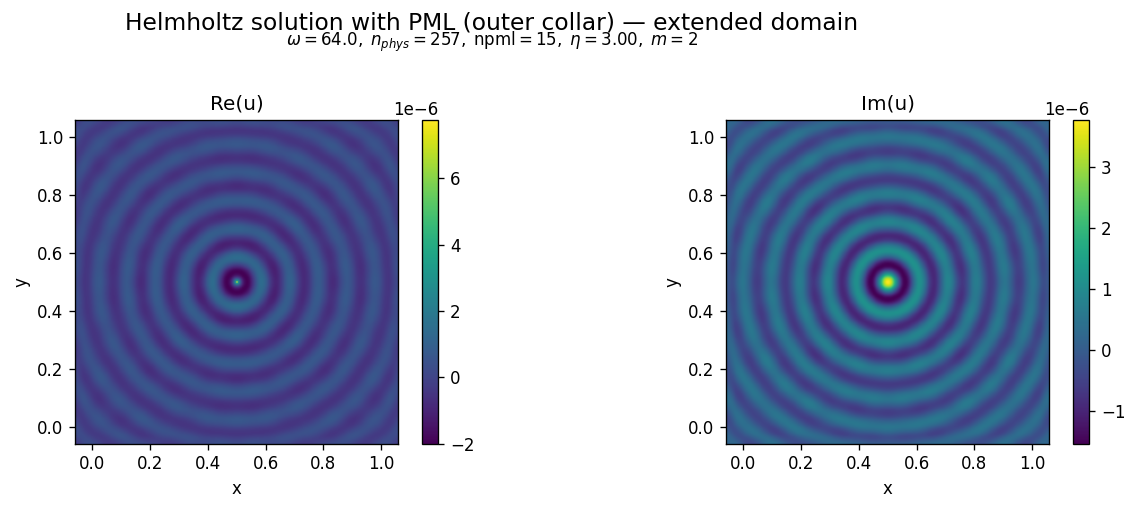

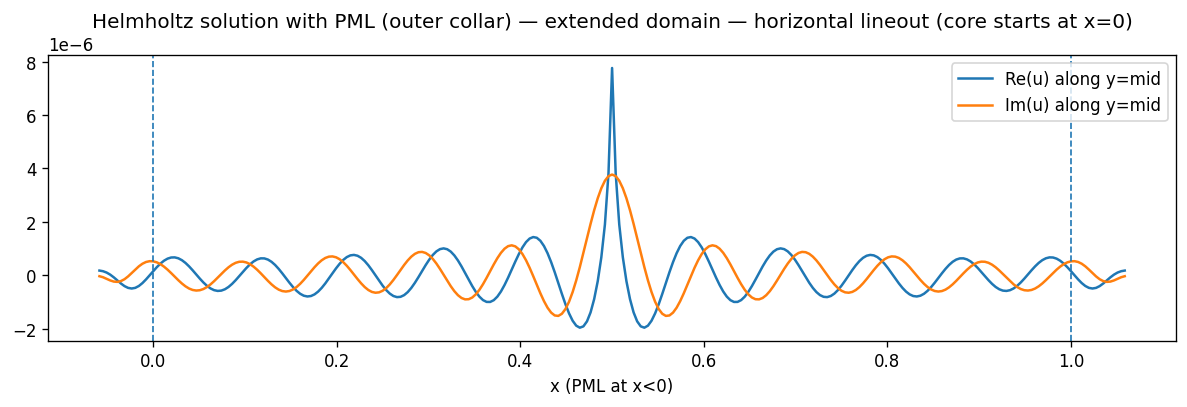

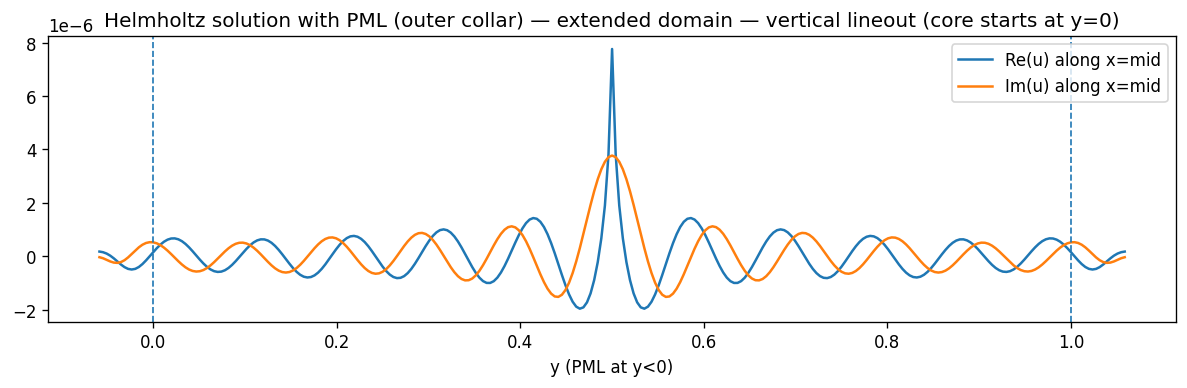

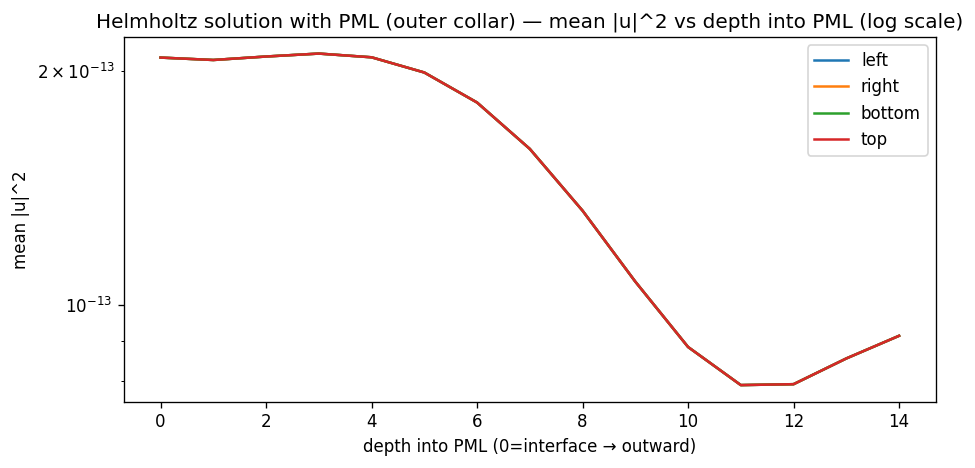

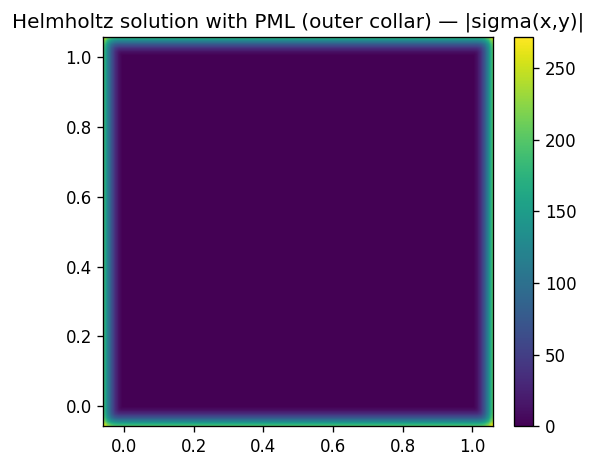

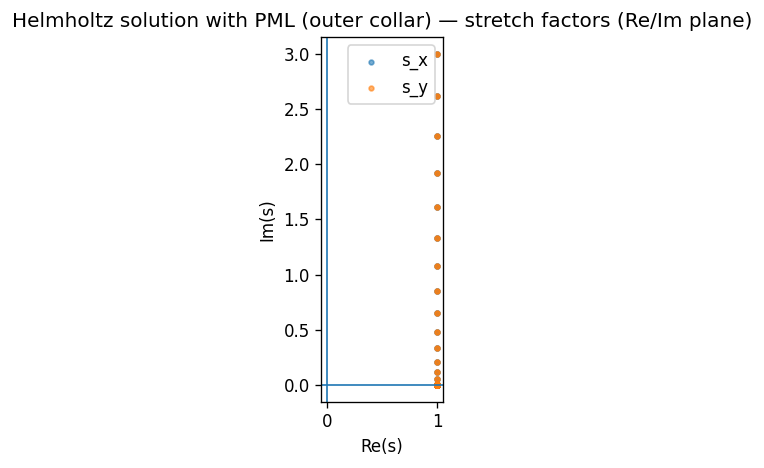


Summary:
  M1_core_ring     : 7.072e-02
  M2_outer_ring    : 2.837e-02
  M3_decay_ratio   : 4.223e-01
  residual (||r||2/||f||2): 3.549e-14

Grid check: phys=257×257, ext=287×287 (adds 30 per axis)
Physical x-range: [0.000, 1.000] | Extended x-range: [-0.059, 1.059]


In [10]:
# --- Single baseline run (outer collar) — robust against stale imports ---

import importlib, inspect
import numpy as np
import operators.solve as opsolve

# 0) Force reload so we don't use an old cached solve_on_extended_domain
importlib.reload(opsolve)
from operators.solve import solve_on_extended_domain

print("Using solve_on_extended_domain from:", opsolve.__file__)
print("Signature:", inspect.signature(solve_on_extended_domain))

# 1) Parameters
omega = 64.0
npml = 15
eta  = 3.0
m    = 2
ppw_target = 10.0

# 2) Build physical-domain fields (NO PML baked in)
cfg_phys = HelmholtzConfig(
    omega=float(omega),
    grid=grid_phys,
    pml=None,
    ppw_target=float(ppw_target),
)

c_phys = build_medium(cfg_phys, case, X_phys, Y_phys)

f_phys = assemble_rhs(cfg_phys, case, X_phys, Y_phys)
f_phys = as_phys_2d(f_phys, grid_phys, name="f_phys")

# 3) Call solve_on_extended_domain safely (only pass x_min/y_min if supported)
kwargs = dict(
    omega=float(omega),
    ppw=float(ppw_target),
    lx=float(Lx),
    ly=float(Ly),
    npml=int(npml),
    m=int(m),
    eta=float(eta),
    c_phys=c_phys,
    f_phys_2d=f_phys,
    n_min_phys=int(n_phys),
    make_odd_phys=True,
    rhs_fill_value=0.0,
)

sig = inspect.signature(solve_on_extended_domain)
if "x_min_phys" in sig.parameters and "y_min_phys" in sig.parameters:
    kwargs["x_min_phys"] = float(grid_phys.x_min)
    kwargs["y_min_phys"] = float(grid_phys.y_min)
else:
    print("WARNING: solve_on_extended_domain does not accept x_min_phys/y_min_phys (old version loaded).")

out = solve_on_extended_domain(**kwargs)

# 4) Unpack
U_ext  = out["U_ext"]
U_phys = out["U_phys"]
norms  = out.get("norms", {})

title = "Helmholtz solution with PML (outer collar)"
subtitle = rf"$\omega={omega:.1f},\;n_{{phys}}={n_phys},\;\mathrm{{npml}}={npml},\;\eta={eta:.2f},\;m={m}$"

# 5) Metrics + plots
mets = reflection_metrics(U_ext, npml=npml, ring=8, outer_ring=8)

plot_re_im_with_extent(U_phys, out["grid_phys"], title + " — physical domain", subtitle)
plot_re_im_with_extent(U_ext,  out["grid_ext"],  title + " — extended domain", subtitle)
plot_lineouts_core_origin(U_ext, out["grid_ext"], npml=npml, title=title + " — extended domain")

plot_pml_decay(pml_decay_profile(U_ext, npml=npml), title=title)

# sigma/stretch diagnostics (optional)
try:
    cfg_ext = out["cfg"]
    c_ref = float(out.get("c_ref", 1.0))
    sig_x, sig_y, sx, sy = build_pml_profiles(cfg_ext, c_ref=c_ref)

    Smag = np.sqrt(sig_x[None, :]**2 + sig_y[:, None]**2)
    plt.figure(figsize=(5, 4))
    plt.imshow(
        Smag, origin="lower",
        extent=[out["grid_ext"].x_min, out["grid_ext"].x_max, out["grid_ext"].y_min, out["grid_ext"].y_max],
    )
    plt.title(title + " — |sigma(x,y)|")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.scatter(sx.real, sx.imag, s=8, alpha=0.6, label="s_x")
    plt.scatter(sy.real, sy.imag, s=8, alpha=0.6, label="s_y")
    plt.axhline(0, linewidth=1); plt.axvline(0, linewidth=1)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.title(title + " — stretch factors (Re/Im plane)")
    plt.xlabel("Re(s)"); plt.ylabel("Im(s)")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot sigma/stretch:", repr(e))

# 6) Summary
print("\nSummary:")
print(f"  M1_core_ring     : {mets['M1_core_ring']:.3e}")
print(f"  M2_outer_ring    : {mets['M2_outer_ring']:.3e}")
print(f"  M3_decay_ratio   : {mets['M3_decay_ratio']:.3e}")
print(f"  residual (||r||2/||f||2): {norms.get('||r||2/||f||2', np.nan):.3e}")

gp = out["grid_phys"]; ge = out["grid_ext"]
print(f"\nGrid check: phys={gp.nx}×{gp.ny}, ext={ge.nx}×{ge.ny} (adds {2*npml} per axis)")
print(f"Physical x-range: [{gp.x_min:.3f}, {gp.x_max:.3f}] | Extended x-range: [{ge.x_min:.3f}, {ge.x_max:.3f}]")


## Sweep npml × eta at fixed ω

Score = M2_outer_ring (lower is better).  
This sweep helps you find the “sweet spot” (not too weak, not too strong).


npml= 10, eta= 0.5 -> M2=9.801e-02 | M3=1.54e+00 | res=3.6e-14
npml= 10, eta= 1.0 -> M2=8.396e-02 | M3=1.90e+00 | res=1.9e-14
npml= 10, eta= 1.5 -> M2=7.620e-02 | M3=1.90e+00 | res=1.6e-14
npml= 10, eta= 2.0 -> M2=6.743e-02 | M3=1.76e+00 | res=1.3e-14
npml= 10, eta= 3.0 -> M2=5.621e-02 | M3=1.41e+00 | res=1.3e-14
npml= 10, eta= 4.0 -> M2=5.236e-02 | M3=1.12e+00 | res=1.5e-14
npml= 10, eta= 6.0 -> M2=5.169e-02 | M3=7.21e-01 | res=1.5e-14
npml= 15, eta= 0.5 -> M2=1.153e-01 | M3=1.27e+00 | res=3.0e-14
npml= 15, eta= 1.0 -> M2=6.725e-02 | M3=1.04e+00 | res=2.3e-14
npml= 15, eta= 1.5 -> M2=4.563e-02 | M3=8.11e-01 | res=2.5e-14
npml= 15, eta= 2.0 -> M2=3.607e-02 | M3=6.40e-01 | res=1.9e-14
npml= 15, eta= 3.0 -> M2=2.837e-02 | M3=4.22e-01 | res=3.5e-14
npml= 15, eta= 4.0 -> M2=2.464e-02 | M3=2.96e-01 | res=2.9e-14
npml= 15, eta= 6.0 -> M2=1.973e-02 | M3=1.60e-01 | res=2.7e-14
npml= 20, eta= 0.5 -> M2=8.802e-02 | M3=2.96e+00 | res=2.3e-14
npml= 20, eta= 1.0 -> M2=4.430e-02 | M3=1.25e+00 | res=

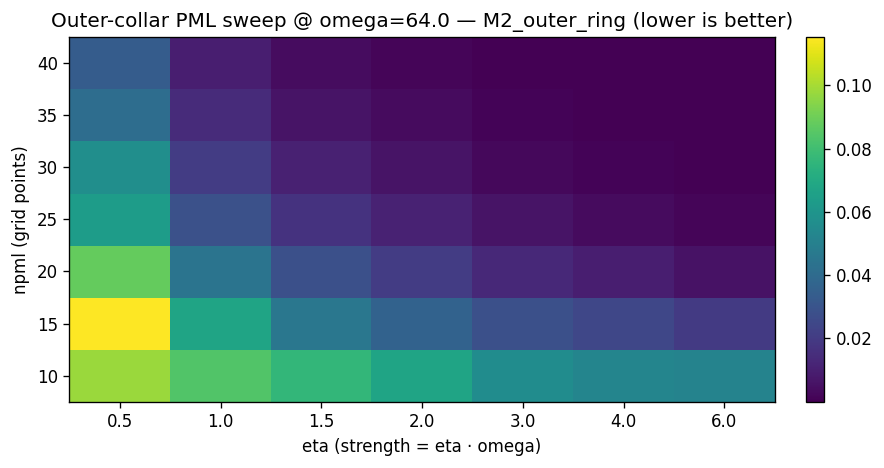

Best in sweep: npml=40, eta=6.0, score=1.896e-05


In [11]:
@dataclass(frozen=True)
class SweepResult:
    score: float
    metrics: Dict[str, float]
    norms: Dict[str, Any]

def run_outer_collar_score(
    *,
    omega: float,
    npml: int,
    eta: float,
    m: int = 2,
    ppw_target: float = 10.0,
    ring: int = 8,
    outer_ring: int = 8,
    rhs_fill_value: float = 0.0,
) -> SweepResult:
    cfg_phys = HelmholtzConfig(omega=float(omega), grid=grid_phys, pml=None, ppw_target=float(ppw_target))

    c_phys = build_medium(cfg_phys, case, X_phys, Y_phys)
    f_phys = assemble_rhs(cfg_phys, case, X_phys, Y_phys)
    f_phys = as_phys_2d(f_phys, grid_phys, name="f_phys")

    out = solve_on_extended_domain(
        omega=float(omega),
        ppw=float(ppw_target),
        lx=float(Lx),
        ly=float(Ly),
        npml=int(npml),
        m=int(m),
        eta=float(eta),
        c_phys=c_phys,
        f_phys_2d=f_phys,
        n_min_phys=int(n_phys),
        make_odd_phys=True,
        rhs_fill_value=float(rhs_fill_value),
    )

    U_ext = out["U_ext"]
    mets = reflection_metrics(U_ext, npml=int(npml), ring=int(ring), outer_ring=int(outer_ring))
    norms = out.get("norms", {})
    score = float(mets["M2_outer_ring"])
    return SweepResult(score=score, metrics=mets, norms=norms)

omega_sweep = 64.0
npml_list = [10, 15, 20, 25, 30, 35, 40]
eta_list  = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 6.0]

scores = np.full((len(npml_list), len(eta_list)), np.nan, dtype=float)

for i, npml in enumerate(npml_list):
    for j, eta in enumerate(eta_list):
        res = run_outer_collar_score(omega=omega_sweep, npml=npml, eta=eta, m=2, ppw_target=10.0)
        scores[i, j] = res.score
        print(
            f"npml={npml:>3d}, eta={eta:>4.1f} -> "
            f"M2={res.score:.3e} | "
            f"M3={res.metrics['M3_decay_ratio']:.2e} | "
            f"res={res.norms.get('||r||2/||f||2', np.nan):.1e}"
        )

plt.figure(figsize=(7.5, 4))
plt.imshow(scores, origin="lower", aspect="auto")
plt.xticks(range(len(eta_list)), [str(e) for e in eta_list])
plt.yticks(range(len(npml_list)), [str(v) for v in npml_list])
plt.xlabel("eta (strength = eta · omega)")
plt.ylabel("npml (grid points)")
plt.title(f"Outer-collar PML sweep @ omega={omega_sweep} — M2_outer_ring (lower is better)")
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

best = np.unravel_index(np.nanargmin(scores), scores.shape)
best_npml = npml_list[best[0]]
best_eta  = eta_list[best[1]]
print(f"Best in sweep: npml={best_npml}, eta={best_eta}, score={scores[best]:.3e}")


## Validate best (npml, eta) across ω ∈ {32, 64, 128}

We keep npml fixed, and (optionally) scale strength with ω through eta.



Validating fixed PML parameters across omegas (outer collar)
---------------------------------------------------------------
ω=  32.0 | npml= 40 eta=6.00 | M1=6.65e-02  M2=1.72e-03  M3=1.72e-02  res=1.28e-14


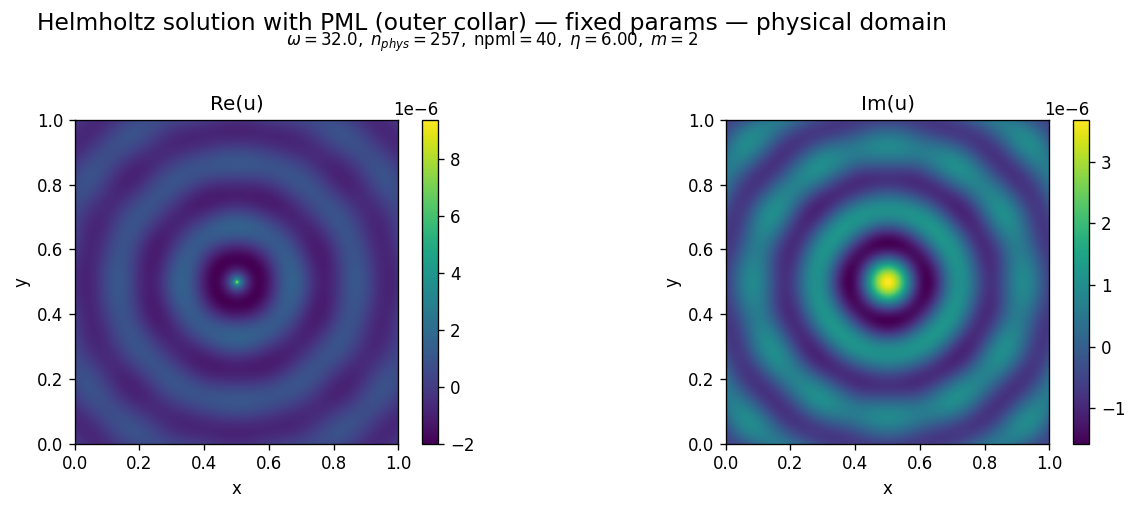

ω=  64.0 | npml= 40 eta=6.00 | M1=6.84e-02  M2=1.90e-05  M3=2.52e-05  res=4.54e-14


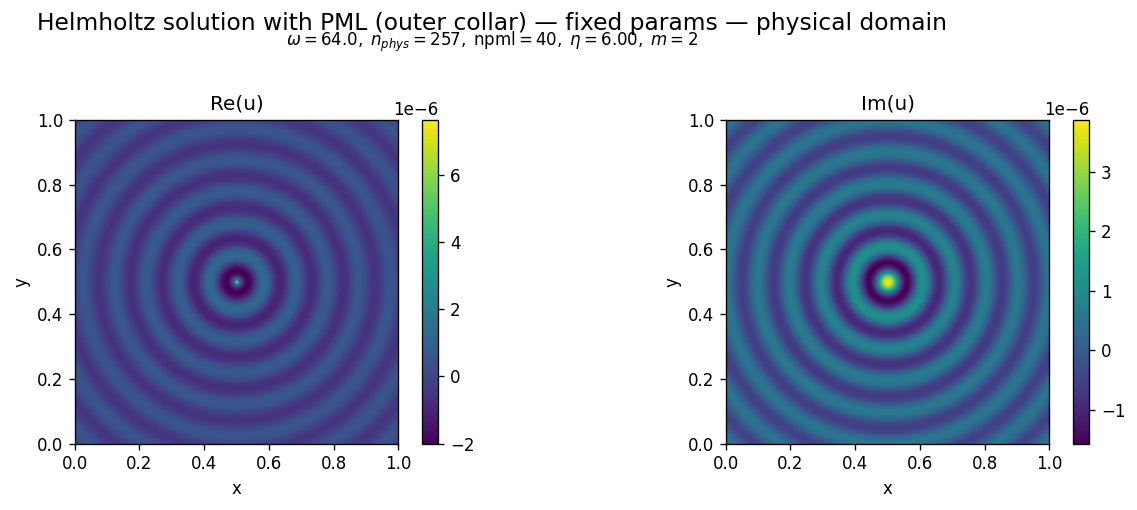

ω= 128.0 | npml= 40 eta=6.00 | M1=6.67e-02  M2=5.25e-09  M3=1.10e-10  res=3.03e-14


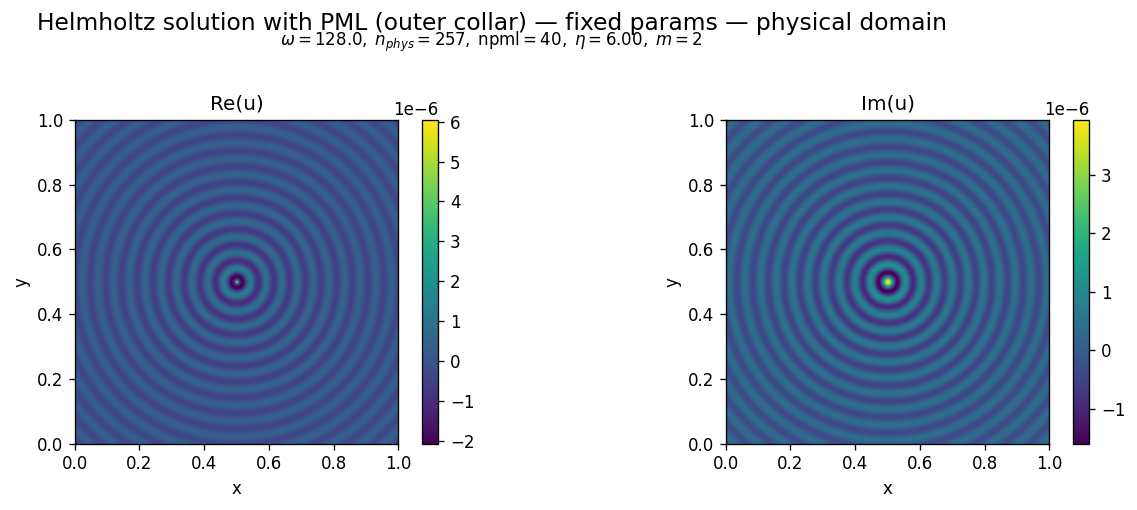

---------------------------------------------------------------
Done.


: 

In [ ]:
NPML_FIXED = int(best_npml)
ETA_FIXED  = float(best_eta)
m = 2
ppw_target = 10.0

print("\nValidating fixed PML parameters across omegas (outer collar)")
print("---------------------------------------------------------------")

for w in OMEGAS:
    cfg_phys = HelmholtzConfig(omega=float(w), grid=grid_phys, pml=None, ppw_target=float(ppw_target))

    c_phys = build_medium(cfg_phys, case, X_phys, Y_phys)
    f_phys = assemble_rhs(cfg_phys, case, X_phys, Y_phys)
    f_phys = as_phys_2d(f_phys, grid_phys, name="f_phys")

    out = solve_on_extended_domain(
        omega=float(w),
        ppw=float(ppw_target),
        lx=float(Lx),
        ly=float(Ly),
        npml=int(NPML_FIXED),
        m=int(m),
        eta=float(ETA_FIXED),
        c_phys=c_phys,
        f_phys_2d=f_phys,
        n_min_phys=int(n_phys),
        make_odd_phys=True,
        rhs_fill_value=0.0,
    )

    U_ext  = out["U_ext"]
    U_phys = out["U_phys"]
    norms  = out.get("norms", {})

    mets = reflection_metrics(U_ext, npml=NPML_FIXED, ring=8, outer_ring=8)

    print(
        f"ω={w:>6.1f} | npml={NPML_FIXED:>3d} eta={ETA_FIXED:>4.2f} | "
        f"M1={mets['M1_core_ring']:.2e}  M2={mets['M2_outer_ring']:.2e}  M3={mets['M3_decay_ratio']:.2e}  "
        f"res={norms.get('||r||2/||f||2', np.nan):.2e}"
    )

    title = "Helmholtz solution with PML (outer collar) — fixed params"
    subtitle = rf"$\omega={w:.1f},\;n_{{phys}}={n_phys},\;\mathrm{{npml}}={NPML_FIXED},\;\eta={ETA_FIXED:.2f},\;m={m}$"
    plot_re_im_with_extent(U_phys, out["grid_phys"], title + " — physical domain", subtitle)

print("---------------------------------------------------------------")
print("Done.")


In [ ]:
print("hx, hy:", out["grid_ext"].hx, out["grid_ext"].hy)
print("sigma_max_base (Laurent):", out["sigma_max_base"])
print("strength used:", out["strength"])
print("R_target:", out["R_target"])


NameError: name 'grid_ext' is not defined